# Demostration:

### This notebook generates a galaxy-galxy strong lensing system in DECaLS condidtion. It uses a real LRG from DECaLS. The source is sersic simply, and taken from Collect (2015).

In [1]:
import cv2
import os
import random as r
import numpy as np
import pandas as pd
from astropy.io import fits

import matplotlib.pyplot as pl
import download_desi_img as ddi
import scipy.fftpack as fftpack

import compose_class as compose_class
from scipy.ndimage import gaussian_filter
from astropy.cosmology import Planck18 as cosmo

In [2]:
##functions

def Fluxr2Sigmav(zlens, re_arcsec, flux_r):
    
    #Use fundamental plane to estimate the velocity disp. of lens galaxy
    #Joseph B. Hyde and Mariangela Bernardi
    #https://doi.org/10.1111/j.1365-2966.2009.14783.x
    
    np.random.seed(19960518)
    
    a_par = 1.4335; b_par = 0.3150; c_par = -8.8979

    Dd_angle = cosmo.angular_diameter_distance(zlens).value                     #Mpc

    re_rad = (re_arcsec/3600) * np.pi / 180
    re_kpc = re_rad * Dd_angle * 1000                                           #kpc

    flux_r_corrected = flux_r * 3.97 / 2
    m_r_corrected = 22.5 - 2.5 * np.log10(flux_r_corrected)
    m_r = 22.5 - 2.5 * np.log10(flux_r)

    miu_e = m_r + 5 * np.log10(re_arcsec) + 2.5 * np.log10(2 * np.pi) - 10 * np.log10(1+zlens)
    sigma = 10** ((1/a_par) * (np.log10(re_kpc) - b_par * miu_e - c_par)) * 1000 #SI
    sigma = sigma * np.random.normal(1, 0.1 , [1, 1])
    
    return sigma[0][0]/1000 #km/s

def MakeCertainFlux(ori,flux):
    return ori * (flux/ori.sum())

def XYTransform(x, y, x_cen, y_cen, phi):
    xnew = (x - x_cen) * np.cos(np.pi * phi / 180.0) + (y - y_cen) * np.sin(np.pi * phi / 180.0)
    ynew = -(x - x_cen) * np.sin(np.pi * phi / 180.0) + (y - y_cen) * np.cos(np.pi * phi / 180.0)
    return (xnew, ynew)

def GetDflAngle(x, y, lpar_local):
    
    # Calculating the img coordinate in source plane of an SIE mass profile following Kormann 1993
    # The convergence has the form of kappa(x, y)=0.5*sqrt(q)*b_sie/sqrt(x^2+q^2*y^2)
    # In this form, b_sie is the Einstein radius in the intermediate-axis convention
    # lpar[0]: lens einstein radius arcsec
    # lpar[1]: lens xcenter
    # lpar[2]: lens ycenter
    # lpar[3]: position angle in degreef
    # lpar[4]: axis ratio
    # lpar[3] = lpar[3]-90
    
    

    if lpar_local[4] > 1.0:
        lpar_local[4] = 1.0 / lpar_local[4]
        lpar_local[3] = lpar_local[3] + 90.0
    if lpar_local[3] > 180.0:
        lpar_local[3] = lpar_local[3] - 180.0
    elif lpar_local[3] < 0.0:
        lpar_local[3] = lpar_local[3] + 180.0
    (xnew, ynew) = XYTransform(x, y, lpar_local[1], lpar_local[2], lpar_local[3])  # rotational matrix
    
    

    r_sie = np.sqrt(xnew ** 2. + ynew ** 2.)
    qfact = np.sqrt((1.0 / lpar_local[4] - lpar_local[4]))
    eps = 10. ** (-8)
    
    if np.abs(qfact) <= eps:  # sie -> sis
        alpha_x = xnew / (r_sie + (r_sie == 0))
        alpha_y = ynew / (r_sie + (r_sie == 0))
    else:
        alpha_x = np.arcsinh(np.sqrt(1.0 / lpar_local[4] ** 2.0 - 1.0) * xnew / (r_sie + (r_sie == 0))) / qfact
        alpha_y =  np.arcsin(np.sqrt(1.0 - lpar_local[4] ** 2.0) * ynew / (r_sie + (r_sie == 0))) / qfact
        
    (alpha_x_new, alpha_y_new) = XYTransform(alpha_x, alpha_y, 0.0, 0.0, -lpar_local[3])
    return  (lpar_local[0]*alpha_x_new, lpar_local[0]*alpha_y_new)

def Sersic(xx,yy,Ie,re,n):
    
    theta = np.sqrt(xx**2+yy**2)
    
    bn = 1.9992*n-0.3271
    res = Ie*np.exp(-bn*((theta/re)**(1/n)-1))
    
    return res

def ApplyMaxValue(ori,max_value):
    scaling_factor = ori.max()/max_value
    return ori*(1/scaling_factor)

def Mag2Flux(mag):
    return 10**((1/2.5)*(22.5-mag))

def GetLensedSRCLight(magg_src,magr_src,magz_src,re_src,beta_xx,beta_yy):
    
    light = Sersic(ptch_sky_xx,ptch_sky_yy,1,re_src,n_src)
    light_g = MakeCertainFlux(light,Mag2Flux(magg_src))
    light_r = MakeCertainFlux(light,Mag2Flux(magr_src))
    light_z = MakeCertainFlux(light,Mag2Flux(magz_src))
    
    max_value_g = light_g.max()
    max_value_r = light_r.max()
    max_value_z = light_z.max()
    
    lnsd_g = ApplyMaxValue(Sersic(beta_xx,beta_yy,1,re_src,n_src),max_value_g)
    lnsd_r = ApplyMaxValue(Sersic(beta_xx,beta_yy,1,re_src,n_src),max_value_r)
    lnsd_z = ApplyMaxValue(Sersic(beta_xx,beta_yy,1,re_src,n_src),max_value_z)
    
    magnification = lnsd_g.sum()/light_g.sum()
    
    return lnsd_g,lnsd_r,lnsd_z,magnification

def ColorIMG(light_g,light_r,light_z):
    
    # function to create a composite png image
    
    max_g = light_g.max()
    max_r = light_r.max()
    max_z = light_z.max()
    img_rscl = max([max_g, max_r, max_z])
    img_thds = 1e-6
    img_g_rscl = light_g/img_rscl
    img_r_rscl = light_r/img_rscl
    img_z_rscl = light_z/img_rscl
    img_g_rscl[np.where(img_g_rscl<=img_thds)] = img_thds
    img_r_rscl[np.where(img_r_rscl<=img_thds)] = img_thds
    img_z_rscl[np.where(img_z_rscl<=img_thds)] = img_thds

    scales, offset, Q, alpha, masklevel, saturation, itype = (0.7,1.05,2.5), 0.0, 100, 0.2, -1.0, 'color', 'sum'
    object_RGB = compose_class.channel_RGB(RED=img_z_rscl, GREEN=img_r_rscl, BLUE=img_g_rscl)
    object_RGB.apply_scale(scales=scales)      
    object_RGB.lupton_stretch(Q=Q, alpha=alpha, itype=itype)
    object_RGB.pjm_mask(masklevel=masklevel)     
    object_RGB.pjm_offset(offset=offset)       
    object_RGB.lupton_saturate(saturation=saturation)
    object_RGB.pack_up()
    
    return object_RGB



def AddPOI(ideal_image=None,exposure=200):
    #add Poisson noise to lensed arcs
    
    image_with_noise = np.copy(ideal_image)
    image_= image_with_noise 
    counts = image_ * exposure  #ideal mean counts
    counts = np.random.poisson(counts, image_.shape) #possion counts base on ideal counts
    image_with_noise = counts*1.0/exposure #subtract the skylevel in image. this work can be done in pre-processing step
    poisson_noise = np.sqrt(counts)
    poisson_noise /= exposure  #-> counts/s
    return image_with_noise, poisson_noise

def CaculateEinsteinRadius(sigma_v,zd,zs):
    
    c=2.996e5 #km/s
    
    Ds_angle  = cosmo.angular_diameter_distance(zs).value         #Mpc
    Dds_angle = cosmo.angular_diameter_distance_z1z2(zd,zs).value #Mpc

    theta_e = 4 * np.pi * (sigma_v/c)**2 * (Dds_angle/Ds_angle) * (180/np.pi) * 3600
    
    return (theta_e)
    

In [3]:
# load in lens catalog

cmass_df = pd.read_csv("./cmass_bright.csv")
# cmass_df = pd.read_csv("./cmass.csv")
pxl_size_real = 0.27

# load in source catalog
# from: https://github.com/tcollett/LensPop (lense_DESa,b,c merged)
source_magi_df = pd.read_csv("./source_magi.csv")

# 1. Lens

## 1.1 Select a Lens Galaxy

In [4]:
#good eg: 1,15 (when load cmass_bright.csv)
cmass_idx = 15
ra  = cmass_df.iloc[cmass_idx]["ra_1"]
dec = cmass_df.iloc[cmass_idx]["dec_1"]
zd  = cmass_df.iloc[cmass_idx]["redshift"]
lens_name_png  = "ra_"+str(ra)+"_dec_"+str(dec)+".png"
lens_name_fits = "ra_"+str(ra)+"_dec_"+str(dec)+".fits"

## 1.2 Observational Stamp of Lens

In [5]:
# download fits and png of the selected lens from Decals Data base

if not os.path.isfile("./stamp/png/"+lens_name_png):
    ddi.DownloadByRaDec_PNG(ra,dec)
if not os.path.isfile("./stamp/fits/"+lens_name_fits):
    ddi.DownloadByRaDec_FITS(ra,dec)

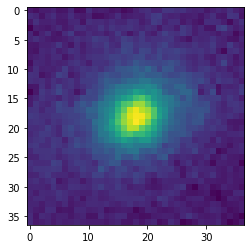

In [6]:
# read out image of the lens

lens_fits = fits.open("./stamp/fits/"+lens_name_fits)
lens_img = lens_fits[0].data
lens_img_g = lens_img[0]
lens_img_r = lens_img[1]
lens_img_z = lens_img[2]

pl.imshow(lens_img_z)

## 1.3 Read Lens Catalog

In [7]:
# read the ellpticity, P.A.,re, flux and redshift
e1_lens = cmass_df.iloc[cmass_idx]["shapedev_e1"]
e2_lens = cmass_df.iloc[cmass_idx]["shapedev_e2"]
re_lens = cmass_df.iloc[cmass_idx]["rg_DEV"] * pxl_size_real  #is the unit of rg_DEV pixel? need check
fluxg_lens = cmass_df.iloc[cmass_idx]["fluxg"]
fluxr_lens = cmass_df.iloc[cmass_idx]["fluxr"]
fluxz_lens = cmass_df.iloc[cmass_idx]["fluxz"]
e_lens  = np.sqrt(e1_lens**2+e2_lens**2)
pa_lens = np.rad2deg(0.5*np.arctan2(e2_lens,e1_lens)) #clockwise direction is postive, +Y is zero
q_lens  = 1-e_lens

lens_img_g = MakeCertainFlux(lens_img_g,fluxg_lens)
lens_img_r = MakeCertainFlux(lens_img_r,fluxr_lens)
lens_img_z = MakeCertainFlux(lens_img_z,fluxz_lens)

## 1.4 Mass Model

In [8]:
sgmv = Fluxr2Sigmav(zd,re_lens,fluxr_lens)
print(sgmv,pa_lens,q_lens,re_lens,e_lens)

354.9688660517708 64.41240878642655 0.812996151357095 1.3815697500000002 0.18700384864290495


# 2. Source

## 2.1 Select a Source Galaxy, Read Source Catalog

In [9]:
source_idx = 199

# SRCS Redshift
zs = source_magi_df.iloc[source_idx].redshift

# light model
n_src    = 1   # index of sersic profile, set according to Collect 2015
re_src   = source_magi_df.iloc[source_idx].re # scaling radius of sersic profile
magg_src = source_magi_df.iloc[source_idx].g
magr_src = source_magi_df.iloc[source_idx].r
magz_src = source_magi_df.iloc[source_idx].z


# 3. Lensed Images

## 3.1 Generate Ideal Lensed Image

In [10]:
# source positions
source_x, source_y = 0.3,0.3 #arcsec,arcsec

# Einstein Radius
theta_e      = CaculateEinsteinRadius(sgmv,zd,zs)

# Lens Parameters to define a SIE profile
lpar = np.array([theta_e,source_x,source_y,pa_lens,q_lens]) 


# generate ideal lensed arcs with ray-tracing method 
# lensing happens at here
# all in arcsec

scl = 5
xmin = -scl
xmax =  scl
ymin = -scl
ymax =  scl

pxl_size = 0.05

ptch_sky_xx, ptch_sky_yy = np.mgrid[xmin:xmax+pxl_size:pxl_size, ymin:ymax+pxl_size:pxl_size]
ptch_sky_xx[ptch_sky_xx==0] = 1e-8
ptch_sky_yy[ptch_sky_yy==0] = 1e-8
alpha_xx, alpha_yy = GetDflAngle(ptch_sky_xx, ptch_sky_yy, lpar)

beta_xx   = ptch_sky_xx   - alpha_xx
beta_yy   = ptch_sky_yy   - alpha_yy

light_src_g,light_src_r,light_src_z,magnification = \
GetLensedSRCLight(magg_src,magr_src,magz_src,re_src,beta_xx,beta_yy)

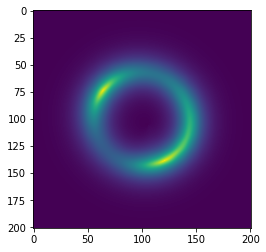

In [11]:
pl.imshow(light_src_g)

## 3.2 PSF & Noise

In [12]:
#add psf

#PSF scale
g_psf_fwhm_decals = 1.26662
r_psf_fwhm_decals = 1.13551
z_psf_fwhm_decals = 1.11053

light_src_g_psf = gaussian_filter(light_src_g, sigma=g_psf_fwhm_decals/pxl_size/2.355)
light_src_r_psf = gaussian_filter(light_src_r, sigma=g_psf_fwhm_decals/pxl_size/2.355)
light_src_z_psf = gaussian_filter(light_src_z, sigma=g_psf_fwhm_decals/pxl_size/2.355)

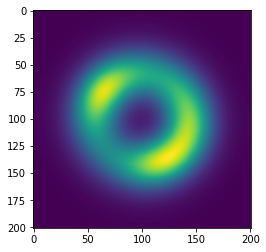

In [13]:
pl.imshow(light_src_g_psf)

In [14]:
#rebin the image to match the pixel size of DeCaLs images
light_src_g_psf_low = cv2.resize(light_src_g_psf,lens_img_g.shape,interpolation=cv2.INTER_CUBIC)
light_src_r_psf_low = cv2.resize(light_src_r_psf,lens_img_r.shape,interpolation=cv2.INTER_CUBIC)
light_src_z_psf_low = cv2.resize(light_src_z_psf,lens_img_z.shape,interpolation=cv2.INTER_CUBIC)

light_src_g_psf_low[light_src_g_psf_low<0] = 1e-20
light_src_r_psf_low[light_src_r_psf_low<0] = 1e-20
light_src_z_psf_low[light_src_z_psf_low<0] = 1e-20

light_src_g_psf_low = MakeCertainFlux(light_src_g_psf_low,light_src_g.sum())
light_src_r_psf_low = MakeCertainFlux(light_src_r_psf_low,light_src_r.sum())
light_src_z_psf_low = MakeCertainFlux(light_src_z_psf_low,light_src_z.sum())

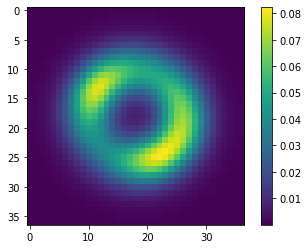

In [15]:
pl.imshow(light_src_g_psf_low)
pl.colorbar()

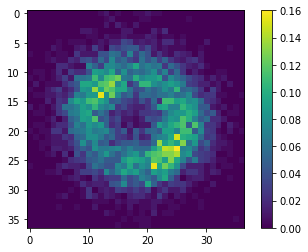

In [16]:
light_src_g_psf_low_poi,t = AddPOI(ideal_image=light_src_g_psf_low,exposure=166)
light_src_r_psf_low_poi,_ = AddPOI(ideal_image=light_src_r_psf_low,exposure=134)
light_src_z_psf_low_poi,_ = AddPOI(ideal_image=light_src_z_psf_low,exposure=200)
pl.imshow(light_src_z_psf_low_poi)
pl.colorbar()

In [17]:
22.5-2.5*np.log10(light_src_g_psf_low.sum()),22.5-2.5*np.log10(light_src_g_psf_low_poi.sum())

(19.110098465096396, 19.099098260222632)

In [18]:
light_src_g_psf_low.sum(),light_src_g_psf_low_poi.sum()

(22.69659007843543, 22.927710843373493)

# 4. Mock g-g SL system

Text(0, 0.5, '$arcsec$')

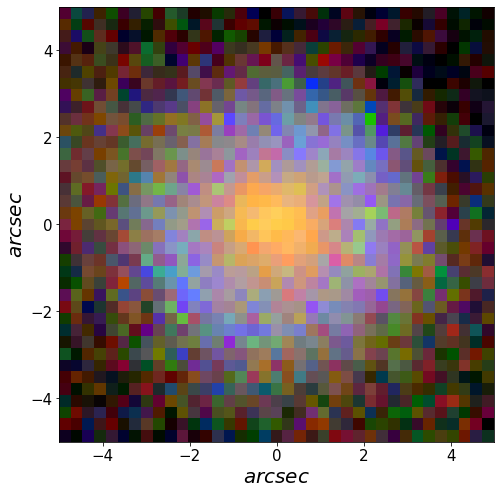

In [19]:
## Paste lensed arcs to the lens image

mock_g = light_src_g_psf_low_poi + lens_img_g
mock_r = light_src_r_psf_low_poi + lens_img_r
mock_z = light_src_z_psf_low_poi + lens_img_z

# create a composite png image to demonstrate the final output
mock_color = ColorIMG(mock_g,mock_r,mock_z)

# visualization
pl.figure(figsize=(8,8))
pl.imshow(mock_color.imgRGB,extent=[-scl,scl,-scl,scl])
t=pl.xticks(fontsize=15)
t=pl.yticks(fontsize=15)
pl.xlabel("$arcsec$",fontsize=20)
pl.ylabel("$arcsec$",fontsize=20)

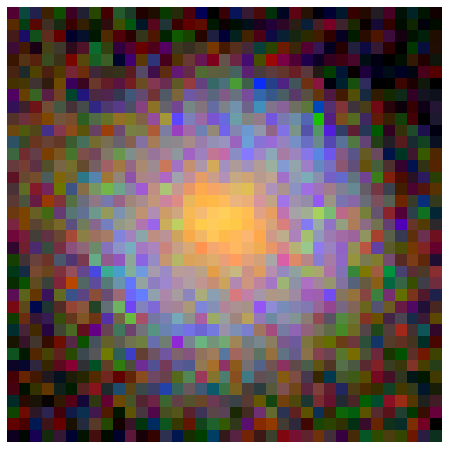

In [20]:
#save
pl.figure(figsize=(8,8))
pl.axis("off")
pl.imshow(mock_color.imgRGB)

if not os.path.exists("./mock"):
    os.system("mkdir ./mock")
    
pl.savefig("./mock/demo.png")

In [21]:
# list the parameters of this mock lens

print("sgmv of lens:", round(sgmv,2),"km/s")
print("magnification:",round(magnification,2))
print("zd,zs,Einstein radius(arcsec):", round(zd,2),round(zs,2),round(theta_e,2),)
print("magi of lens   (g,r,z):",\
      round(cmass_df.iloc[cmass_idx]["g"],2),round(cmass_df.iloc[cmass_idx]["r"],2),round(cmass_df.iloc[cmass_idx]["z"],2))
print("magi of source (g,r,z):",magg_src,magr_src,magz_src)
print("lensed source fluxr / lens fluxr:",round(light_src_r.sum()/lens_img_r.sum(),2))

sgmv of lens: 354.97 km/s
magnification: 7.45
zd,zs,Einstein radius(arcsec): 0.38 1.17 2.16
magi of lens   (g,r,z): 19.86 18.23 17.35
magi of source (g,r,z): 21.29 20.98 20.89
lensed source fluxr / lens fluxr: 0.59
